In [27]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# IMPORTING LAYERS, ARCHITECTURES, ETC
from tensorflow.keras.applications import vgg19, vgg16
from tensorflow.keras.applications.resnet import ResNet152
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

import os, cv2
import zipfile
from sklearn.model_selection import train_test_split

In [11]:
!curl https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  3 65.4M    3 2414k    0     0  1836k      0  0:00:36  0:00:01  0:00:35 1834k
 10 65.4M   10 6784k    0     0  2927k      0  0:00:22  0:00:02  0:00:20 2926k
 13 65.4M   13 8992k    0     0  2718k      0  0:00:24  0:00:03  0:00:21 2717k
 16 65.4M   16 10.6M    0     0  2539k      0  0:00:26  0:00:04  0:00:22 2538k
 20 65.4M   20 13.5M    0     0  2617k      0  0:00:25  0:00:05  0:00:20 2833k
 23 65.4M   23 15.3M    0     0  2499k      0  0:00:26  0:00:06  0:00:20 2674k
 26 65.4M   26 17.1M    0     0  2402k      0  0:00:27  0:00:07  0:00:20 2157k
 30 65.4M   30 19.8M    0     0  2446k      0  0:00:27  0:00:08  0:00:19 2266k
 40 65.4M   40 26.5M    0     0  2921k      0  0:00

In [21]:
local_zip = 'cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('Data/tmp')
zip_ref.close()
base_dir = os.getcwd()+'\\Data\\tmp\\cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [25]:
train_cat_files = [os.path.join(train_cats_dir, x) for x in os.listdir(train_cats_dir)]
train_dog_files = [os.path.join(train_dogs_dir, x) for x in os.listdir(train_dogs_dir)]
valid_cat_files = [os.path.join(validation_cats_dir, x) for x in os.listdir(validation_cats_dir)]
valid_dog_files = [os.path.join(validation_dogs_dir, x) for x in os.listdir(validation_dogs_dir)]

print("Train files: ", len(train_cat_files) + len(train_dog_files))
print("Validation files: ", len(valid_cat_files) + len(valid_dog_files))

Train files:  2000
Validation files:  1000


In [31]:
all_files = train_cat_files + train_dog_files + valid_cat_files + valid_dog_files
images = np.empty(len(all_files), dtype=object)
labels = np.empty(len(all_files), dtype=object)
classes = {0: 'cat', 1: 'dog'}
for n in range(0, len(all_files)):
    images[n] = cv2.imread(all_files[n])
    images[n] = cv2.cvtColor(images[n], cv2.COLOR_BGR2RGB)
    labels[n] = [0 if 'cat.' in all_files[n] else 1]

In [32]:
images_resized = [cv2.resize(x, (220, 128)) for x in images]

[1]


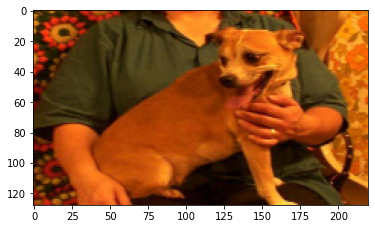

In [33]:
plt.imshow(images_resized[1500])
print(labels[1500])

In [50]:
import random

def fill(img, h, w):
    img = cv2.resize(img, (220, 128), cv2.INTER_CUBIC)
    return img

def h_shift(img):
    ratio = random.uniform(-0.2, 0.2)
    h,w = img.shape[:2]
    to_shift = w*ratio
    if ratio > 0:
        img = img[:, :int(w-to_shift), :]
    if ratio < 0:
        img = img[:, int(-1*to_shift):, :]
    img = fill(img, h, w)
    return img

def v_shift(img):
    ratio = random.uniform(-0.2, 0.2)
    h, w = img.shape[:2]
    to_shift = h*ratio
    if ratio > 0:
        img = img[:int(h-to_shift), :, :]
    if ratio < 0:
        img = img[int(-1*to_shift):, :, :]
    img = fill(img, h, w)
    return img

def rotation(img):
    angle = int(random.uniform(-45, 45))
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    return img

def add_transforms(imgs, n_transforms=3, array=[], new_labels=[], labels=labels):
    for i in range(0, len(imgs)):
        array.append(rotation(imgs[i]))
        new_labels.append(labels[i])
    
    for i in range(0, len(imgs)):
        array.append(h_shift(imgs[i]))
        new_labels.append(labels[i])
        array.append(v_shift(imgs[i]))
        new_labels.append(labels[i])
    return array, new_labels

In [51]:
images_transformed, labels_transformed = add_transforms(images_resized)

[0]


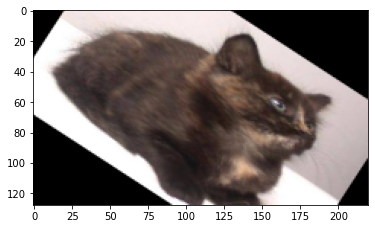

In [52]:
plt.imshow(images_transformed[100])
print(labels_transformed[100])

In [53]:
total_imgs = len(images_transformed)
total_lbls = len(labels_transformed)
print('Total number of imgs: ', total_imgs, '\nTotal number of labels: ', total_lbls)

Total number of imgs:  9000 
Total number of labels:  9000


In [54]:
import pandas as pd

df = pd.DataFrame(labels_transformed)
df[0].value_counts()

0    4500
1    4500
Name: 0, dtype: int64

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images_transformed, labels_transformed, test_size=0.3, random_state=42)
X_train = np.array(X_train)
X_test = np.array(X_test)

print("Shape of Train Data: ", X_train.shape, "\nShape of Test Data: ", X_test.shape)

Shape of Train Data:  (6300, 128, 220, 3) 
Shape of Test Data:  (2700, 128, 220, 3)


In [57]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
print("Shape of Train Labels: ", y_train_cat.shape, "\nShape of Test Labels: ", y_test_cat.shape)

Shape of Train Labels:  (6300, 2) 
Shape of Test Labels:  (2700, 2)


(128, 220, 3)
[0]


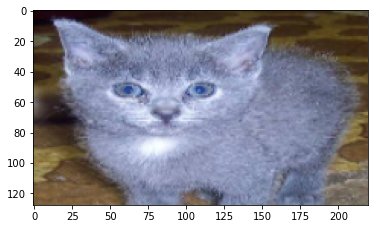

In [58]:
print(X_train[0].shape)
print(y_train[0])
plt.imshow(X_train[0])

In [59]:
opt_adam = Adam(learning_rate=0.00001)
model_resnet = ResNet152(include_top=True, weights=None, input_shape=(128, 220, 3), classes=2)
model_resnet.compile(optimizer=opt_adam, loss='categorical_crossentropy', metrics=['accuracy'])
model_resnet.summary()

Model: "resnet152"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 220, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 226, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 110, 64)  9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 110, 64)  256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [ ]:
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=4, verbose=1, restore_best_weights=True)
history = model_resnet.fit(X_train, y_train_cat, batch_size=56, epochs=10, validation_data=(X_test, y_test_cat), verbose=1, callbacks=[earlystop])
model_resnet.save('/Documents/Notebooks/models/model_resnet152.h5')

In [61]:
model_vgg16 = vgg16.VGG16(include_top=True, weights=None, input_shape=(128, 220, 3), classes=2)
model_vgg16.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics='accuracy')
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 220, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 220, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 220, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 110, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 110, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 110, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 55, 128)       0     

In [ ]:
model_vgg16.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), batch_size=56, epochs=10, verbose=1)

In [63]:
model_vgg19 = vgg19.VGG19(include_top=True, weights=None, input_shape=(128, 220, 3), classes=2)
model_vgg19.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics='accuracy')
model_vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 220, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 220, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 220, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 110, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 110, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 110, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 55, 128)       0     

In [ ]:
model_vgg19.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), batch_size=56, epochs=10, verbose=1)

In [ ]:
model_vgg16.save('/content/model_vgg16.h5')
model_vgg19.save('/content/model_vgg19.h5')